In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [94]:
def import_basel_data():
    data = pd.read_csv("raw_data/Basel_Daten.csv", delimiter=';')
    return data

def get_location_data(df, location):
    mask = df['SiteName'] == location
    return df[mask], df[~mask]

def clean_location_data(location_df):
    stamps = [x.split('+')[0] for x in location_df['DateTimeFrom'].values]
    location_df = location_df.assign(Time=pd.to_datetime(stamps.copy(), format="%Y-%m-%dT%H:%M:%S"))
    location_df = location_df.set_index('Time')
    return location_df

def get_location_split_dict(data):
    location_dict = {}
    #Alle Orte
    locs = sorted(list(set(data['SiteName'])))
    for loc in locs:
        location_df, data = get_location_data(data, loc)
        location_dict[loc] = clean_location_data(location_df)
    return location_dict

def resample_location_data(location_df, frequency):
    if frequency == 'D':
        cols = ['Total']
    elif frequency == 'H':
        cols = ['Total', 'Month', 'Weekday', 'HourFrom']
    else:
        print("INCORRECT FREQUENCY")
    location_df = location_df[cols].resample(frequency).sum()
    return location_df

In [95]:
data = import_basel_data()
location_hourly_sum = {}
location_daily_sum = {}
for loc, loc_data in get_location_split_dict(data).items():
    location_daily_sum[loc] = resample_location_data(loc_data, 'D')    
    location_hourly_sum[loc] = resample_location_data(loc_data, 'H')

In [96]:
location_daily_sum['802 Klybeckstrasse 113/Kirche'].head()

,Total
Time,
2019-01-31,146
2019-02-01,1639
2019-02-02,2025
2019-02-03,836
2019-02-04,1808


In [111]:
location_hourly_sum['802 Klybeckstrasse 113/Kirche']

,Total,Month,Weekday,HourFrom
Time,,,,
2019-01-31 20:00:00,41,1,3,20
2019-01-31 21:00:00,48,1,3,21
2019-01-31 22:00:00,39,1,3,22
2019-01-31 23:00:00,18,1,3,23
2019-02-01 00:00:00,13,2,4,0
2019-02-01 01:00:00,8,2,4,1
2019-02-01 02:00:00,5,2,4,2
2019-02-01 03:00:00,1,2,4,3
2019-02-01 04:00:00,7,2,4,4


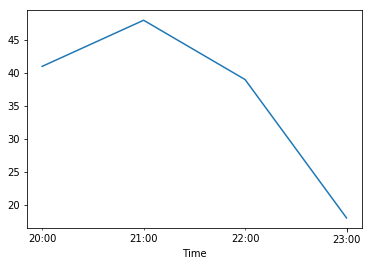

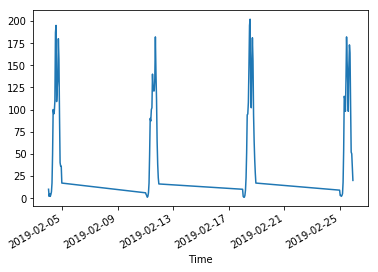

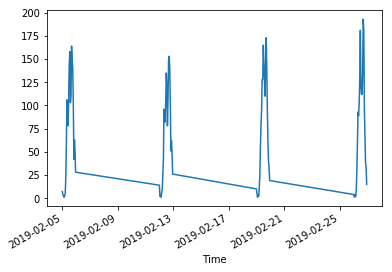

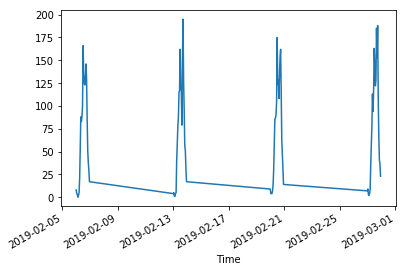

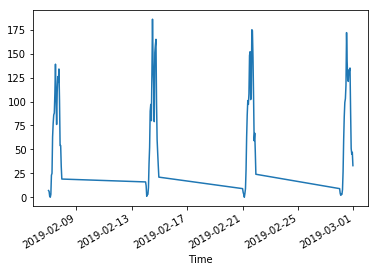

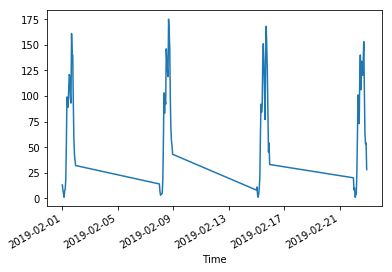

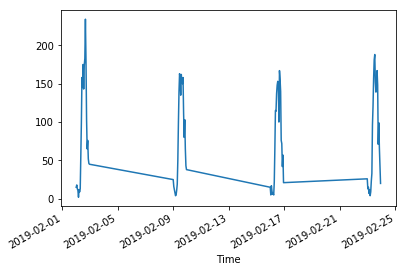

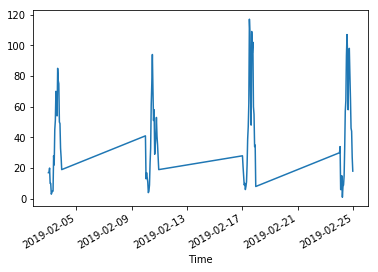

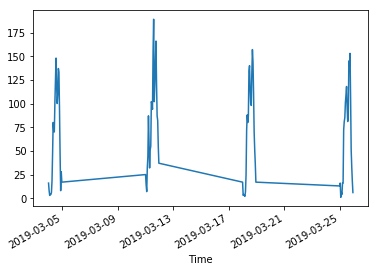

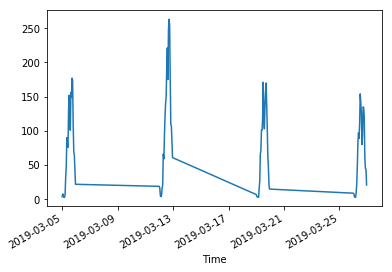

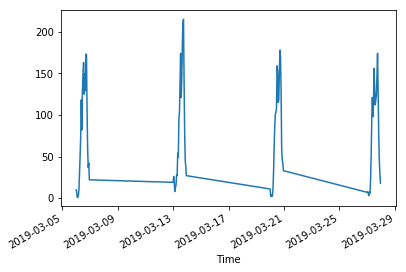

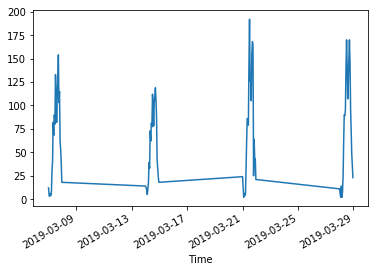

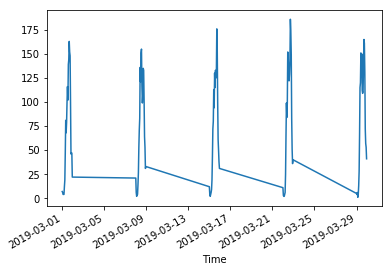

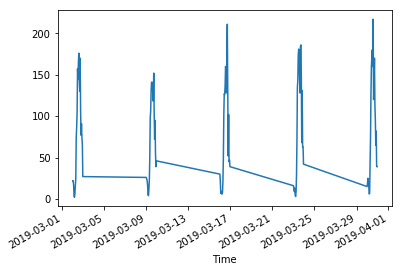

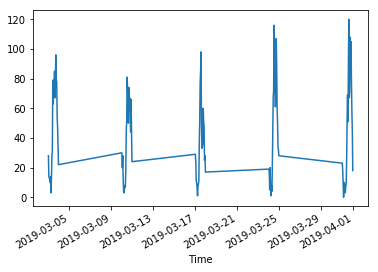

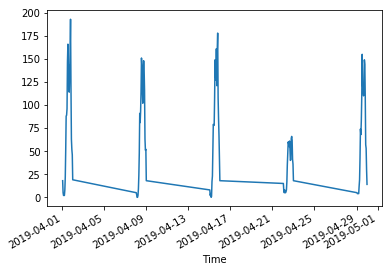

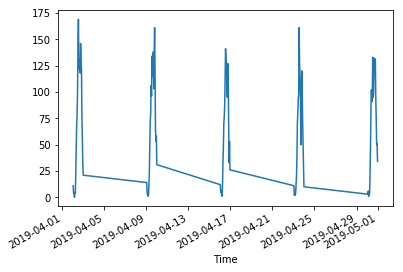

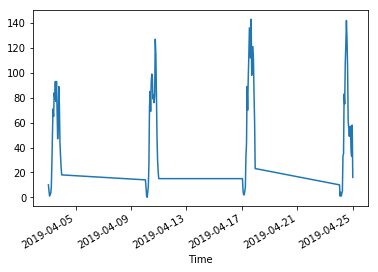

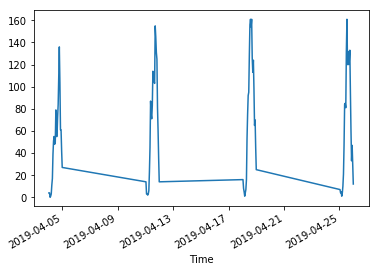

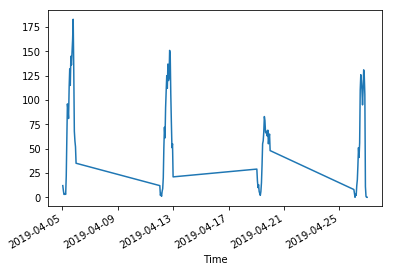

In [110]:
%matplotlib inline

data_by_day = {"%d:%d"%(mk,dk):dv.sort_values(by=['HourFrom']) for mk, mv in location_hourly_sum['802 Klybeckstrasse 113/Kirche'].groupby('Month')
                                                                     for dk, dv in mv.groupby('Weekday')}
for i in range(1, 21):
    #print(list(data_by_day.values())[i])
    list(data_by_day.values())[i]['Total'].plot()
    plt.show()